In [12]:
# ###################################
# Group ID: 222
# Members: Adrián Gómez Repollés, Kresten Johansen, Misbah Unnisa, Mohammadali Zakeriharandi
# Date: 21/06/2024
# Lecture: Lecture 9: Multilayer perceptrons
# Dependencies: pytorch, torchvision, torcheval, Matplotlib, seaborn
# Python version: 3.11.5
# Functionality: Jupyter notebook to train an MLP model on MNIST dataset using PyTorch
# ###################################

In [1]:
%%bash
nvidia-smi

Thu Mar 21 14:56:29 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:73:00.0  On |                  N/A |
| 35%   43C    P8    11W / 250W |    282MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%reload_ext watermark
%watermark -a "Mohammadali Zakeriharandi"
%watermark -v -p torch,torchvision,torcheval

Author: Mohammadali Zakeriharandi

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

torch      : 2.1.2
torchvision: 0.16.2
torcheval  : 0.0.7



In [3]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as fcn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as v2
from torcheval.metrics.functional import multiclass_accuracy

## Load Data

In [4]:
class MNIST(Dataset):
    def __init__(self, data_path, train=True):
        super().__init__()

        files = dict()
        for file_name in os.listdir(data_path):
            files[file_name.replace(".pt", "")] = torch.load(os.path.join(data_path, file_name))
        
        if train:
            self.data, self.targets = files["data_tr"], files["targets_tr"]
        else:
            self.data, self.targets = files["data_ts"], files["targets_ts"]

        self.transform = v2.Compose([v2.ToImage(), v2.ToDtype(dtype=torch.float, scale=True)])

    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        sample = self.transform(self.data[idx, :, :])
        label = self.targets[idx]
        return sample, label
    

In [5]:
data_path = "./data/MNIST/splitted"
dataset_tr = MNIST(data_path=data_path, train=True)
dataset_val = MNIST(data_path=data_path, train=False)

print("Training Datsaet:", dataset_tr.data.shape, dataset_tr.targets.shape)
print("Test Datsaet:", dataset_val.data.shape, dataset_val.targets.shape)

Training Datsaet: torch.Size([60000, 28, 28]) torch.Size([60000])
Test Datsaet: torch.Size([10000, 28, 28]) torch.Size([10000])


In [6]:
sample_0, label_0 = dataset_tr[0]
sample_0.shape, label_0.shape

(torch.Size([1, 28, 28]), torch.Size([]))

## Visualize Samples

In [7]:
def show_sample(sample, label, ax):
    ax.imshow(sample.squeeze(), cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"label={label}")

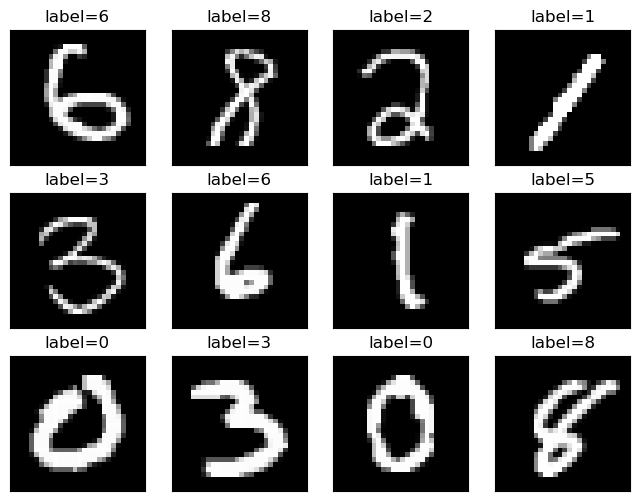

In [8]:
idxs = torch.randint(0, len(dataset_tr), (12,))  # 12 random indices
fig, axs = plt.subplots(3, 4, figsize=(8, 6))
for idx, ax in zip(idxs, axs.flatten()):
    sample, label = dataset_tr[idx]
    show_sample(sample, label, ax)

### Model Building
- <u>Input Layer</u>: The model expects an input size of 28*28, which corresponds to the flattened MNIST images, each being 28-by-28 pixels.

- <u>Hidden Layers</u>: There are three sequential hidden layers in the network:

    - The first hidden layer (`layer1`) applies a linear transformation to map the 784-dimensional input to a 32-dimensional space and then applies a ReLU activation function. The ReLU activation introduces non-linearity, enabling the network to learn complex patterns.

    - The second hidden layer (`layer2`) further transforms the data from 32 dimensions to 64 dimensions, again followed by a ReLU activation.

    - The third hidden layer (`layer3`) maps the 64-dimensional space to a 128-dimensional space, with another ReLU activation applied.

- <u>Output Layer</u>: The final layer (`layer4`) is a linear layer that transforms the 128-dimensional representation from the third hidden layer to a 10-dimensional output. Each dimension of the output corresponds to one of the ten classes (digits 0-9) in the MNIST dataset.

- <u>Network Composition</u>: The `self.network` attribute combines all these layers into a `nn.ModuleList`, allowing for <u>sequential processing</u> of input data through these layers.

In [9]:
class MyModel(nn.Module):
    def __init__(self, in_features=28*28, hid_dims=[32, 64, 128], num_classes=10):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=in_features, out_features=hid_dims[0]),
            nn.ReLU()
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(in_features=hid_dims[0], out_features=hid_dims[1]),
            nn.ReLU()
        )

        self.layer3 = nn.Sequential(
            nn.Linear(in_features=hid_dims[1], out_features=hid_dims[2]),
            nn.ReLU()
        )

        self.layer4 = nn.Sequential(
            nn.Linear(in_features=hid_dims[2], out_features=num_classes)
        )

        self.network = nn.ModuleList(
            [self.layer1, self.layer2, self.layer3, self.layer4])

    def forward(self, data):
        for module_ in self.network:
            data = module_(data)

        return data

Note:
Even though we are solving a classification problem, there is <u>no softmax layer</u> at the end of the network, which would convert the logits to probabilities. This design choice is common in classification tasks in <u>PyTorch</u>.  When combined with loss functions like `nn.CrossEntropyLoss` in PyTorch, the softmax operation is <u>internally computed</u> within the loss function. This integrated approach is more efficient and numerically stable. 

## Training Loop

In [10]:
def visualize_performance(loss_trs, acc_trs, loss_vals, acc_vals):

    # Move to cpu
    loss_trs_cpu = [loss_tr.to(device="cpu") for loss_tr in loss_trs]
    loss_vals_cpu = [loss_val.to(device="cpu") for loss_val in loss_vals]
    acc_trs_cpu = [acc_tr.to(device="cpu") for acc_tr in acc_trs]
    acc_vals_cpu = [acc_val.to(device="cpu") for acc_val in acc_vals]

    sns.set_style("whitegrid")
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].plot(loss_trs_cpu, label="Training")
    axs[0].plot(loss_vals_cpu, label="Validation")
    axs[0].set_title("Loss")
    axs[0].legend()

    axs[1].plot(acc_trs_cpu, label="Training")
    axs[1].plot(acc_vals_cpu, label="Validation")
    axs[1].set_title("Accuracy")
    axs[1].legend()

    return fig

Training Model 1:

epoch[0] | loss_tr: 2.30469012260437 | acc_tr: 0.09871666878461838
epoch[0] | loss_val: 2.3032467365264893 | acc_val: 0.09828571230173111

epoch[10] | loss_tr: 2.1012368202209473 | acc_tr: 0.19438335299491882
epoch[10] | loss_val: 2.0779831409454346 | acc_val: 0.21095238626003265

epoch[20] | loss_tr: 1.4344285726547241 | acc_tr: 0.4926500916481018
epoch[20] | loss_val: 1.4085465669631958 | acc_val: 0.4940952658653259

epoch[30] | loss_tr: 0.8065217137336731 | acc_tr: 0.7527000904083252
epoch[30] | loss_val: 0.8100884556770325 | acc_val: 0.7447618842124939

epoch[34] | loss_tr: 0.7347678542137146 | acc_tr: 0.7742500305175781
epoch[34] | loss_val: 0.737609326839447 | acc_val: 0.7681905627250671



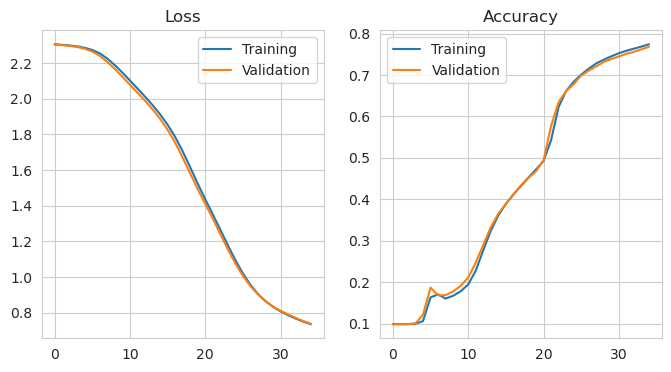

Training Model 2:

epoch[0] | loss_tr: 2.3052759170532227 | acc_tr: 0.09911666065454483
epoch[0] | loss_val: 2.3029277324676514 | acc_val: 0.09733334183692932

epoch[10] | loss_tr: 2.0573644638061523 | acc_tr: 0.33090004324913025
epoch[10] | loss_val: 2.0137641429901123 | acc_val: 0.3529524505138397

epoch[20] | loss_tr: 0.7248611450195312 | acc_tr: 0.787899911403656
epoch[20] | loss_val: 0.6866491436958313 | acc_val: 0.8023809790611267

epoch[30] | loss_tr: 0.4768049418926239 | acc_tr: 0.8630663752555847
epoch[30] | loss_val: 0.46448659896850586 | acc_val: 0.864476203918457

epoch[34] | loss_tr: 0.44063207507133484 | acc_tr: 0.8740832209587097
epoch[34] | loss_val: 0.43280231952667236 | acc_val: 0.8730476498603821



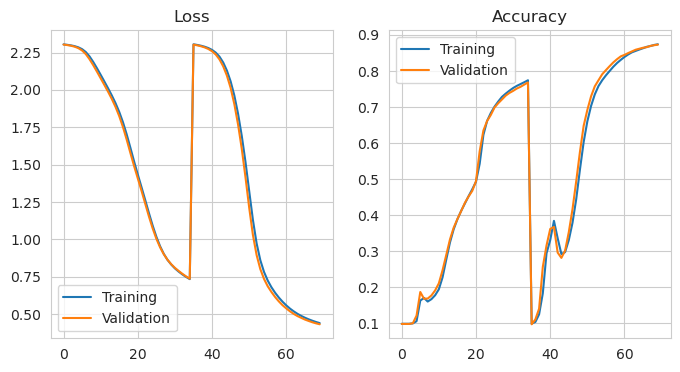

Training Model 3:

epoch[0] | loss_tr: 2.3008570671081543 | acc_tr: 0.10441668331623077
epoch[0] | loss_val: 2.298386573791504 | acc_val: 0.1036190539598465

epoch[10] | loss_tr: 2.093963146209717 | acc_tr: 0.43768349289894104
epoch[10] | loss_val: 2.0415267944335938 | acc_val: 0.454571396112442

epoch[20] | loss_tr: 0.6080815196037292 | acc_tr: 0.8225666880607605
epoch[20] | loss_val: 0.5765730142593384 | acc_val: 0.8279048204421997

epoch[30] | loss_tr: 0.43016311526298523 | acc_tr: 0.875916600227356
epoch[30] | loss_val: 0.42193707823753357 | acc_val: 0.8726666569709778

epoch[34] | loss_tr: 0.40121397376060486 | acc_tr: 0.8837500810623169
epoch[34] | loss_val: 0.39471447467803955 | acc_val: 0.8808571696281433



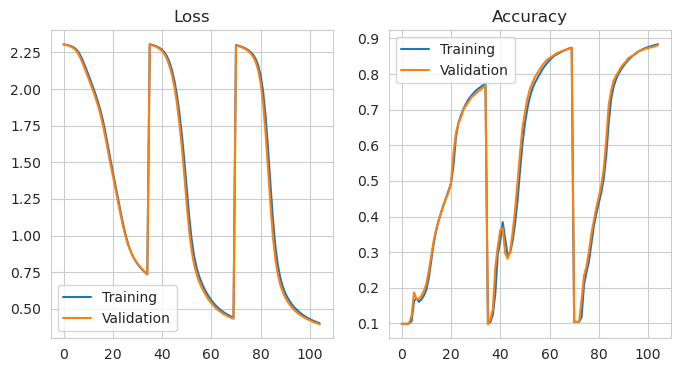

In [11]:
# Create DataLoader objects
batch_size = 750
dataloader_tr = DataLoader(dataset_tr, batch_size=batch_size, shuffle=True, drop_last=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, drop_last=False)

# Build Model (changing no. hidden units in each layer)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_1 = MyModel(in_features=28*28, hid_dims=[8, 16, 32], num_classes=10).to(device=device)
model_2 = MyModel(in_features=28*28, hid_dims=[16, 32, 64], num_classes=10).to(device=device)
model_3 = MyModel(in_features=28*28, hid_dims=[32, 64, 128], num_classes=10).to(device=device)
models = [model_1, model_2, model_3]

# training parameters
num_epochs = 35
lr  =1e-2
cost_fcn = nn.CrossEntropyLoss(reduction="mean")
loss_trs, loss_vals = [], []  # training and validatio loss
acc_trs, acc_vals = [], []  # training and validatio accuracies


# Train
for i, model in enumerate(models):
    print(f"Training Model {i+1}:")
    optimizer = optim.SGD(params=model.parameters(), lr=lr)
    model.train()
    for epoch in range(num_epochs):
        loss_tr = torch.tensor(0, dtype=torch.float, device=device)  # epoch loss
        acc_tr = torch.tensor(0, dtype=torch.float, device=device)  # epoch accuracy

        for X_b, y_b in dataloader_tr:
            X_b, y_b = X_b.to(device=device), y_b.to(device=device)  # Move data to device

            # forward pass
            model.zero_grad()  # reset gradients
            Z_b = model(X_b)  # logits

            # backward pass
            loss_b = cost_fcn(Z_b, y_b)  # cost_fcn(logits, labels)
            loss_b.backward()
            acc_b = multiclass_accuracy(input=fcn.softmax(Z_b, dim=1), target=y_b.squeeze())

            # update
            optimizer.step()

            # accumulated training loss and accuracy
            loss_tr = loss_tr + loss_b.item() 
            acc_tr = acc_tr + acc_b
        
        loss_trs.append(loss_tr/len(dataloader_tr))
        acc_trs.append(acc_tr/len(dataloader_tr))

        # Evaluate
        model.eval()
        with torch.no_grad():
            loss_val = torch.tensor(0, dtype=torch.float, device=device)  # epoch loss
            acc_val = torch.tensor(0, dtype=torch.float, device=device)  # epoch accuracy

            for X_b, y_b in dataloader_val:
                X_b, y_b = X_b.to(device=device), y_b.to(device=device)
                Z_b = model(X_b)  # logits

                # Compute loss and accuracy
                loss_b = cost_fcn(Z_b, y_b)
                acc_b = multiclass_accuracy(input=fcn.softmax(Z_b, dim=1), target=y_b.squeeze())

                # accumulated validation loss and accuracy
                loss_val = loss_val + loss_b.item()
                acc_val = acc_val + acc_b
            
            loss_vals.append(loss_val / len(dataloader_val))
            acc_vals.append(acc_val/len(dataloader_val))

            
        if epoch % 10 == 0:
            print(f"\nepoch[{epoch}] | loss_tr: {loss_trs[-1]} | acc_tr: {acc_trs[-1]}")
            print(f"epoch[{epoch}] | loss_val: {loss_vals[-1]} | acc_val: {acc_vals[-1]}")

    print(f"\nepoch[{epoch}] | loss_tr: {loss_trs[-1]} | acc_tr: {acc_trs[-1]}")
    print(f"epoch[{epoch}] | loss_val: {loss_vals[-1]} | acc_val: {acc_vals[-1]}\n")
    visualize_performance(loss_trs, acc_trs, loss_vals, acc_vals)
    plt.show()


It is observed that increasing the number of hidden units in each layar has increased the overall accuracy. The last model having 32, 64, and 128 units in its layers can reach to 88% validation accuracy. However, this occurs at the expense of unstable training, where for some epochs, the loss increases. To overcome this, we can modify the network's architecture. Increasing the number of training epochs could also be a solution.  